# ROB311 - TP #1
# K-Nearest Neighbors
**Brice Tayart**

1st Lab assignment for the *Machine learning for Robotics* course at ENSTA by Prof. Adriana Tapus. 

---
**Subject:**

*Write a python program to implement K-NN to work with several   datasets.*
*Please verify with the 2 datasets below (Breast Cancer Wisconsin and Haberman's Survival). Calculate also the confusion matrix, the accuracy, and plot the data.*

### Breast Cancer Wisconsin
#### Loading data
The data csv il retrieved directly on internet and laoded into a Pandas DataFrame. 16 rows with incomplete data are removed from the dataset.

The data is further split into a set of *features* $\in \{0,...,10\}^9$and a set of *labels* $\in \{0,1\}$


In [1]:
#%% import packages
import numpy as np
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#%% Load data from breast cancer data
# read data into a dataframe
# below are column labels as found in the .name file
'''
7. Attribute Information: (class attribute has been moved to last column)

   #  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)


The data also have duplicate samples (same sample code, 2 interpretations)
'''
filename = 'breast-cancer-wisconsin'
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/"+filename+"/"+filename+".data"

col_names = ['ID',
             'Clump_Thickness',
             'Uniformity_of_Cell_Size',
             'Uniformity of Cell Shape',
             'Marginal Adhesion',
             'Single Epithelial Cell Size',
             'Bare Nuclei',
             'Bland Chromatin',
             'Normal Nucleoli',
             'Mitoses',
             'Class']
# Read and cleanup data (16 entries with "?" to be dropped)
df = pd.read_csv(url, header=None, names=col_names, na_values="?")
df=df.set_index('ID')
df=df.dropna(how='any')

# extract 0/1 labels
label = df["Class"]
label = (label//2)-1 #0/1 labelling

#extract features
features = df.iloc[:,:-1]

The *pairplot* function from ***Seaborn*** package is used to plot each features one against another

Since features have integer values in the $[0,10]$ range, there are only 121 possible combinations, i.e. several points will be drawn at the same place.

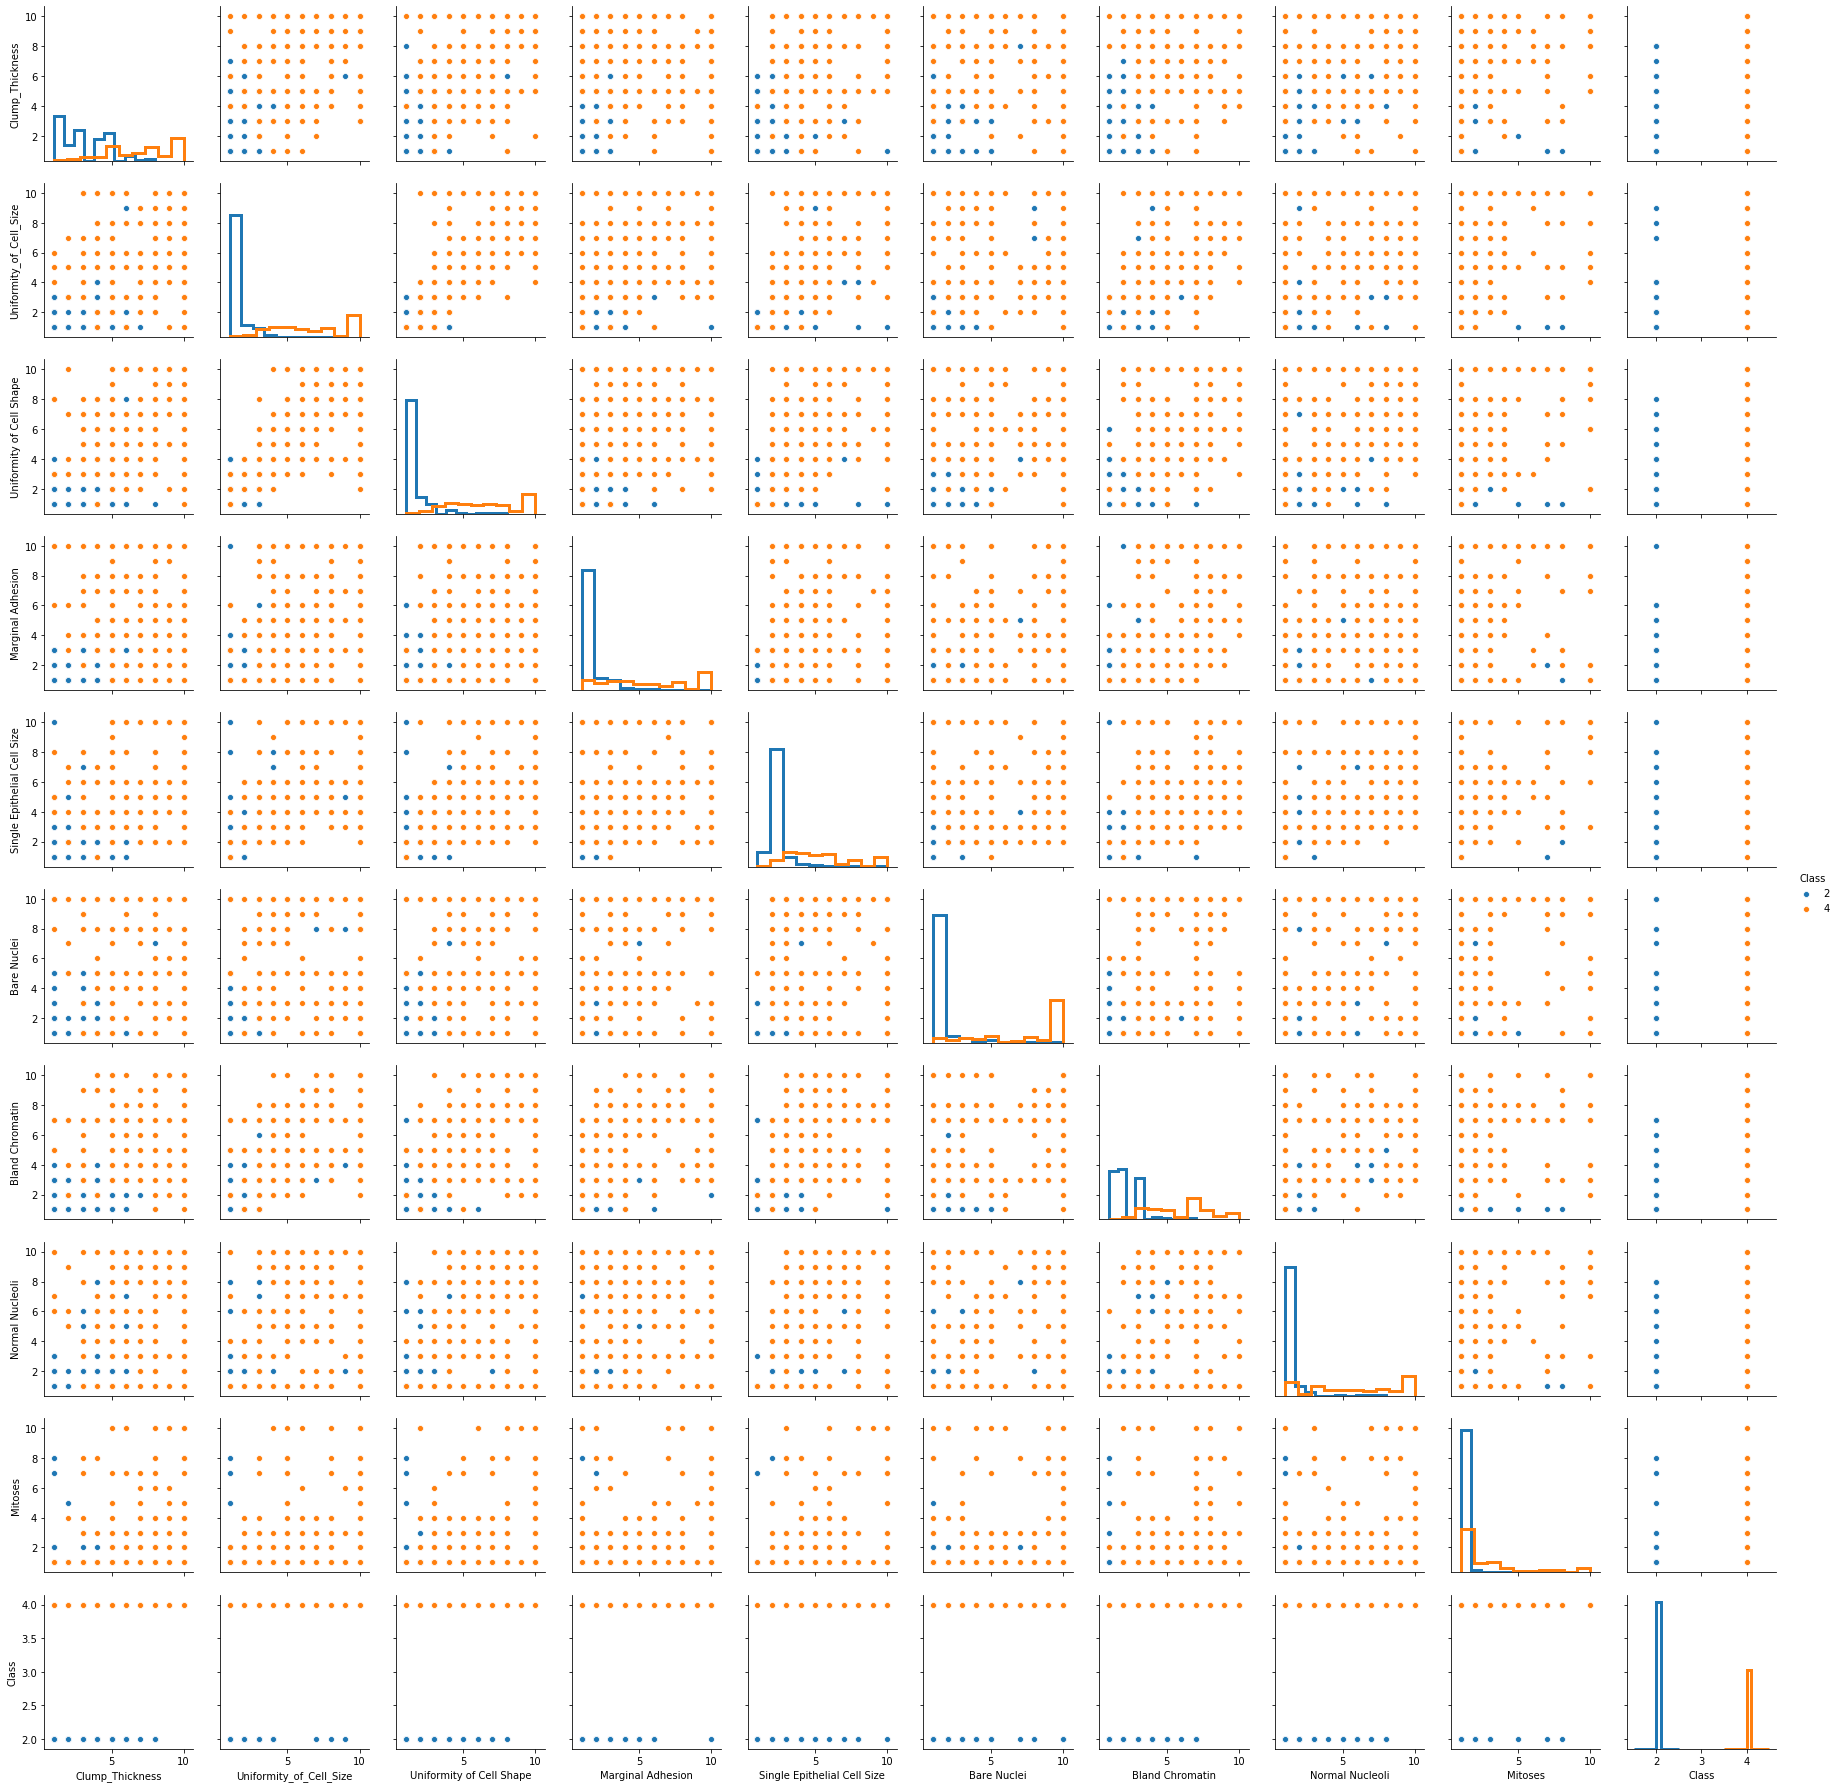

In [3]:
sns.pairplot(df,hue="Class",diag_kind="hist", diag_kws={"histtype":"step", "linewidth":3});

The following code provides a customized pair-plot with density represented as the marker area

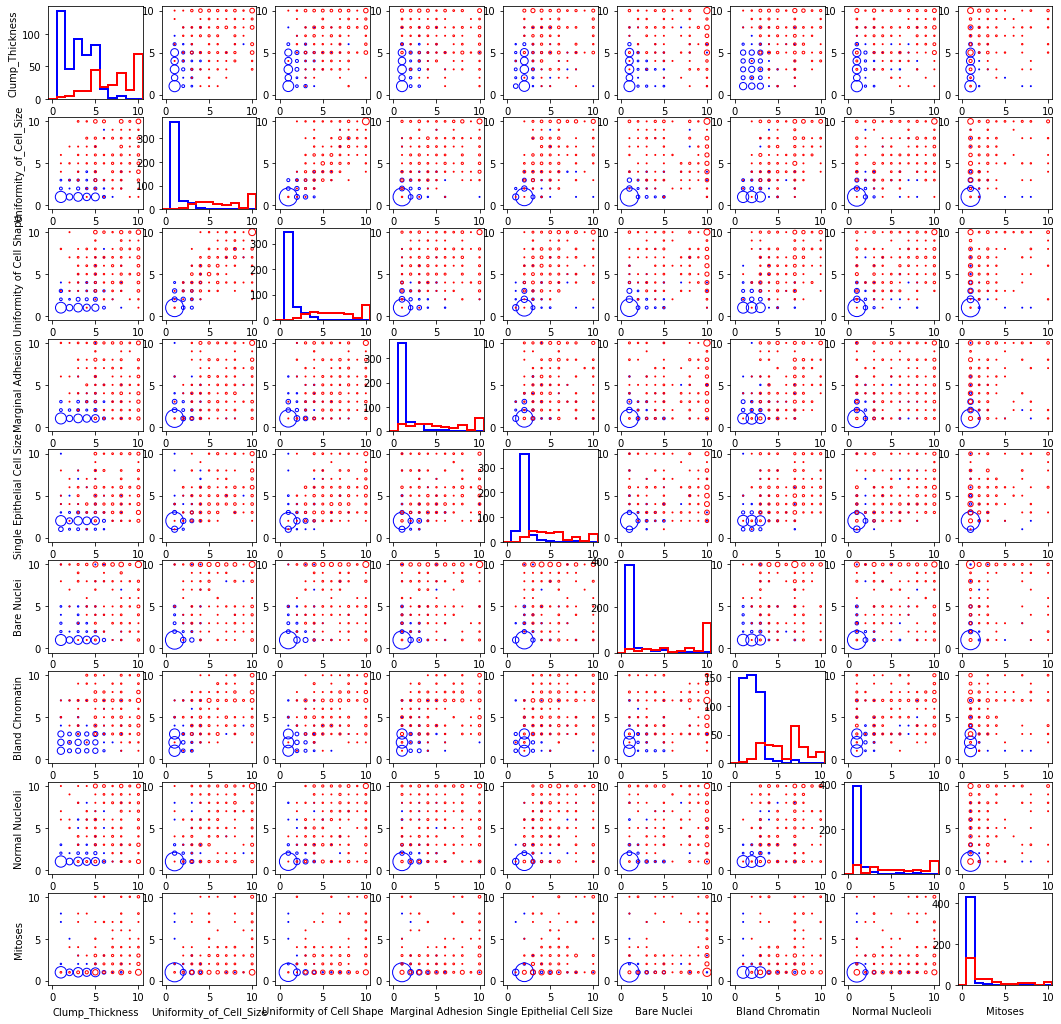

In [4]:
fig = plt.figure(figsize=(18,18))

#Loop through the pairs of features
for ii,C1 in enumerate(features):
    for jj,C2 in enumerate(features):
        
        
        ax = plt.subplot(9,9,ii+9*jj+1)
        
        #Create an histogram on the diagonal
        if ii==jj:
            for lab,cc in enumerate('br'):
                plt.hist(df[label==lab][C1], bins=np.linspace(-.5,10.5,12),
                         histtype='step', linewidth=2, color=cc)
                
        #Create a scatter plot out of the diagonal, counting how many (x,y) pairs we have
        if ii!=jj:
            C1 = df.columns[ii]
            C2 = df.columns[jj]
            for lab,cc in enumerate('br'):
                v = df[label==lab].groupby([C1,C2,]).count().iloc[:,0]
                coord = np.array(v.index.to_list())
                siz = v.to_numpy()
                ax.scatter(coord[:,0],coord[:,1],s=siz,marker='o',facecolors='none',edgecolors=cc);
            plt.ylim(-.5,10.5)
        plt.xlim(-.5,10.5)
        
        #label axes on the left and bottom
        if ii==0:
            ax.set_ylabel(C2)
        if jj==len(features.columns)-1:
            ax.set_xlabel(C1)

It is to be noted that for all features, benign tumors seem clustered around 0 while malignant tumors have values spread over the full 0-10 range

### K-Nearast-Neighbors class
A class with *fit* and *predict* methods is used in order to compute the K-nearest neighbors
The class assumes that features X ans labels y have the same order (the integer index of the DataFrame is used rather than the sample ID)

The key principle is:
- upon calling the *fit* method, a copy of the features and labels is saved in attributes *__Xtr* and *__ytr*
- upon calling the *predict* method on features dataframe *X*: the K closest neighbors of each row of *X* are sought. This involves computing the distance of each coodinate (i.e. with $X_{tr} \in\mathbb{R}^{n \times k}$ and $X \in\mathbb{R}^{m \times k}$, we have a $n \times m \times k$ values). These are raised to the power $p$ (depnding on which norm $\mathcal L_p$ is used) and summed along the last axis. A partial sort with *np.argpartition* is done to extract, for each row of $X$, the K closest neighbors.

A *score* method is also implemented which, for a set $(X_{test}, y_{test})$ of features and labels, returns a 2x2 confusion matrix with the count of true positives, etc...

In [5]:
#%% Functions
class k_nearest_neighbors():
    '''Class to implement kNN classification with a 0/1 index'''
    k = 1
    dist_norm = 2
    __Xtr = None
    __ytr = None
    
    def fit(self, X_train, y_train):
        '''saves a copy of the data into the object
        X train saved as a (1 x n x p) ndarray'''
        tmp = X_train.to_numpy()
        self.__ytr = y_train.to_numpy()
        self.__Xtr = tmp.reshape((1, tmp.shape[0], tmp.shape[1]))



    def predict(self, X, k=None, dist_norm=None):
        '''seeks the label according to k nearest neighbors
        For each input row, the Lp distance with all known points is computed
        (actually the last step of taking the p-th root skipped, as this does
        not affect which point is closest)
        The output is the average of the k nearest neighbors, rounded
        '''
        if self.__Xtr is None:
            return None

        # Override class attribute with function argument if any
        k, dist_norm = self.__attributes_override(k, dist_norm)
        
        # Allocate the output
        out = np.zeros(X.shape[0])
        
        # Extract Xarr as a (m x 1 x p) array
        Xarr = X.to_numpy()
        Xarr = Xarr.reshape(( Xarr.shape[0], 1, Xarr.shape[1]))
        
        # Broadcast subtraction of Xarr and Xtr gives a (m x n x p) array
        # This is then summed to give a distance
        dist = np.sum(np.abs(Xarr-self.__Xtr)**dist_norm, axis=2)

        # use np.arpartition to parially sort the data and get k first values
        ind_near = np.argpartition(dist, k-1, axis = 1)
        ind_near = ind_near[:,:k]
        # extract labels for the k nearest points
        # then output 1 if more than half are >=1
        near_labels = self.__ytr[ind_near]
        near_sum = 2*np.sum(near_labels>=1, axis=1) >=k
        
        out = np.array(near_sum ,dtype=int)
        #return (out,near_labels)
        return out

    def score(self, X_test, y_test, k=None, dist_norm=None):
        '''Returns the number of correct predictions'''
        if self.__Xtr is None:
            return None
        
        # Override class attribute with function argument if any
        _k, _dist_norm = self.__attributes_override(k, dist_norm)
        
        y_pred = self.predict(X_test, k=_k, dist_norm=_dist_norm)
        return np.sum(y_pred==y_test.to_numpy())

    def confusion_matrix(self, X_test, y_test, k=None, dist_norm=None):
        '''Create the confusion matrix for a given test dataset
        conf[i,j] is the number of occurrences with actual label i
        vs predicted label j'''
        if self.__Xtr is None:
            return None
        
        # Override class attribute with function argument if any
        _k, _dist_norm = self.__attributes_override(k, dist_norm)
        
        y_pred = self.predict(X_test, k=_k, dist_norm=_dist_norm)
        out = np.zeros((2,2))
        for ii in (0,1):
            for jj in (0,1):
                out[ii,jj] = np.sum(np.logical_and(y_test==ii , y_pred==jj))
        return out
            
    def  __attributes_override(self,k, dist_norm):
        ''' Override class attribute with function argument if any'''
        if k is None:
            k = self.k
        if dist_norm is None:
            dist_norm = self.dist_norm
        return (k, dist_norm)
    
    def __init__(self, k=1, dist_norm=1):
        self.k = k
        self.dist_norm = dist_norm

A *conf_attibute* function is done that extrats some attributes from a $2 \times 2 \times k$ array of confusion matrices: accuracy, precision, recall, F1-score

In [6]:
def conf_attributes(mat):
    '''extract attributes from a confusion matrix'''
    if mat.size==4:
        mat=mat.reshape((2,2,1))
        
    #Accuracy: proportion of events propoerly predicted
    acc = (mat[0,0,:]+mat[1,1,:])/np.sum(mat.reshape(4,-1), axis=0)
    
    #Precision: proportion of actually positive event among thos predicted as positive
    prec = mat[1,1,:]/np.sum(mat[:,1,:],axis=0)
    
    #Recall: proportion of actually positive events that are correctly predicted as positive
    rec = mat[1,1,:]/np.sum(mat[1,:,:],axis=0)
    
    #F1 score
    F1 = 2/(1/prec + 1/rec)

    return {'accuracy':acc, 'precision':prec, 'recall': rec, 'F1 score':F1}

### Breast Cancer Wisconsin
#### Data analysis

We are now ready to process the data from the Breast Cancer Wisconsin database

The dataset is split into a training set with 80% of the data and a test set, using ***scikit learn*** *Test_train_split* tool.

In order to choose the parameter K and the norm to be used ($\mathcal{L}_1$, $\mathcal{L}_2$ and the uncommon $\mathcal{L}_3$} a further K-fold cross validation is done, training the class on 75% of the train set and evaluating the prediction quality on the remaining 25% of the train set.

In both cases, the *stratified* option is used to keep an about constant proportion of positive and negative labels across all datasets.

In [7]:
#%% Split dataset in test + train
# Split the dataset into a train and a test set, then create a Kfold cross validation iterator
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        features, label, test_size = .2)

kf = model_selection.StratifiedKFold(n_splits=5)

# Test from 1 to 61 by increment of 4
k_test = np.arange(1,62,4, dtype='int')
eval_L1 = np.zeros((2,2,k_test.size))
eval_L2 = np.zeros((2,2,k_test.size))
eval_L3 = np.zeros((2,2,k_test.size))

#Loop over the K folds for cross_validation
knn = k_nearest_neighbors()
for ind_tr, ind_cv in kf.split(X_train,y_train):
    knn.fit(X_train.iloc[ind_tr], y_train.iloc[ind_tr])
    for ii,kk in enumerate(k_test):
        eval_L1[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=1)
        eval_L2[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=2)
        eval_L3[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=3)        

The evolution of accuracy, precison etc is plotted as the number K varies, for each of the norms.

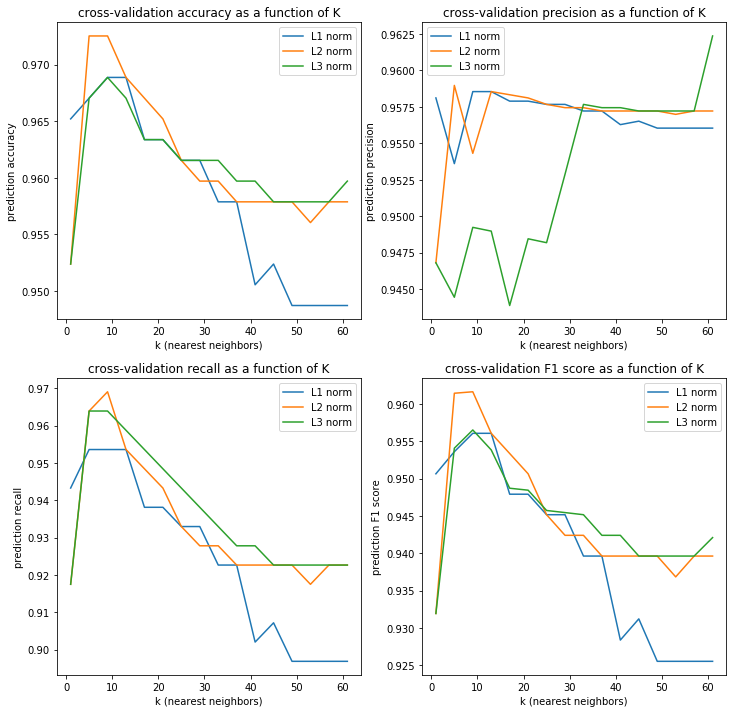

In [8]:
evaluation_L1 = conf_attributes(eval_L1)
evaluation_L2 = conf_attributes(eval_L2)
evaluation_L3 = conf_attributes(eval_L3)

fig=plt.figure(figsize=(12,12))
for ii,param in enumerate(evaluation_L1):
    ax=plt.subplot(2,2,ii+1)
    ax.plot(k_test,evaluation_L1[param], label="L1 norm")
    ax.plot(k_test,evaluation_L2[param], label="L2 norm")
    ax.plot(k_test,evaluation_L3[param], label="L3 norm")
    ax.set_ylabel("prediction "+param)
    ax.set_xlabel("k (nearest neighbors)");
    plt.title("cross-validation "+param+" as a function of K")
    plt.legend()

The best results are most of the time obtained with $\mathcal{L}_2$ norm and K=5.

There is some variation as the training set and K-fold cross validation sets are randomly selected; $\mathcal{L}_2$ / K=9 and $\mathcal{L}_3$ / K=5 sometime perform equally well

The full training set is then used to train the data, and its performance is evaluated on the training set.

In [9]:
kk = 5
dist_norm = 2

knn = k_nearest_neighbors()
knn.fit(X_train, y_train)
confusion = knn.confusion_matrix(X_test, y_test, k=kk, dist_norm=dist_norm)
evaluation = conf_attributes(confusion)

print("The confusion matrix is:\n")
print("                 | Predict malignant | Predict benign |")
print("-----------------|------------------------------------|")
print("Actual malignant |          %5d    |       %5d    |"%(confusion[1,1],confusion[1,0]))
print("-----------------|------------------------------------|")
print("Actual benign    |          %5d    |       %5d    |"%(confusion[0,1],confusion[0,0]))
print("-----------------|------------------------------------|")

print("\nEvaluation metrics are :")
for key,val in evaluation.items():
    print(key+" = %5.3f"%val)

The confusion matrix is:

                 | Predict malignant | Predict benign |
-----------------|------------------------------------|
Actual malignant |             41    |           4    |
-----------------|------------------------------------|
Actual benign    |              3    |          89    |
-----------------|------------------------------------|

Evaluation metrics are :
accuracy = 0.949
precision = 0.932
recall = 0.911
F1 score = 0.921


### Haberman's survival
#### Loading data

In [10]:
#%% Load data from Haberman's survival
# read data into a dataframe
# below are column labels as found in the .name file
'''
7. Attribute Information:
   1. Age of patient at time of operation (numerical)
   2. Patient's year of operation (year - 1900, numerical)
   3. Number of positive axillary nodes detected (numerical)
   4. Survival status (class attribute)
         1 = the patient survived 5 years or longer
         2 = the patient died within 5 year
'''

# The data also have duplicate samples (same sample code, 2 interpretations)

filename = 'haberman'
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/"+filename+"/"+filename+".data"
col_names = ['Age',
             'Year of operation',
             'Number of axiliary nodes',
             'Survival']
# Read and cleanup data (16 entries with "?" to be dropped)
df = pd.read_csv(url, header=None, names=col_names)

# extract 0/1 labels
label = df["Survival"]
label = label-1 #0/1 labelling

#extract features
features = df.iloc[:,:-1]

#### Visualization

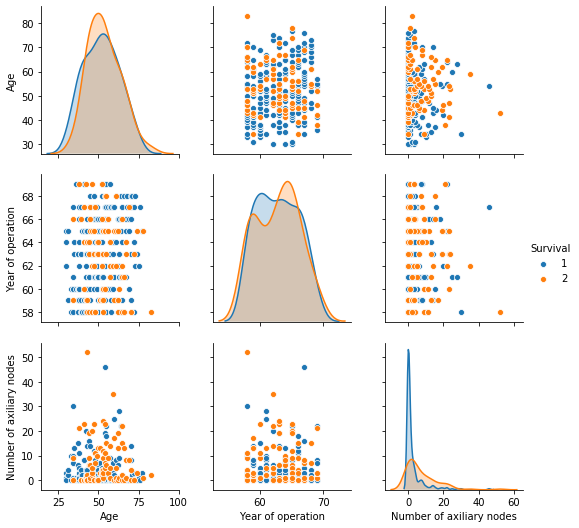

In [11]:
sns.pairplot(df,hue="Survival",vars=df.columns[:-1]);

#### Analysis 

In [25]:
#%% Split dataset in test + train
# Split the dataset into a train and a test set, then create a Kfold cross validation iterator
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        features, label, test_size = .2)

kf = model_selection.StratifiedKFold(n_splits=5)

# Test from 1 to 61 by increment of 4
k_test = np.arange(1,62,4, dtype='int')
eval_L1 = np.zeros((2,2,k_test.size))
eval_L2 = np.zeros((2,2,k_test.size))
eval_L3 = np.zeros((2,2,k_test.size))

#Loop over the K folds for cross_validation
knn = k_nearest_neighbors()
for ind_tr, ind_cv in kf.split(X_train,y_train):
    knn.fit(X_train.iloc[ind_tr], y_train.iloc[ind_tr])
    for ii,kk in enumerate(k_test):
        eval_L1[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=1)
        eval_L2[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=2)
        eval_L3[:,:,ii] += knn.confusion_matrix(X_train.iloc[ind_cv], y_train.iloc[ind_cv], k=kk, dist_norm=3)        

The evolution of accuracy, precison etc is plotted as the number K varies, for each of the norms.

/home/btayart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/btayart/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


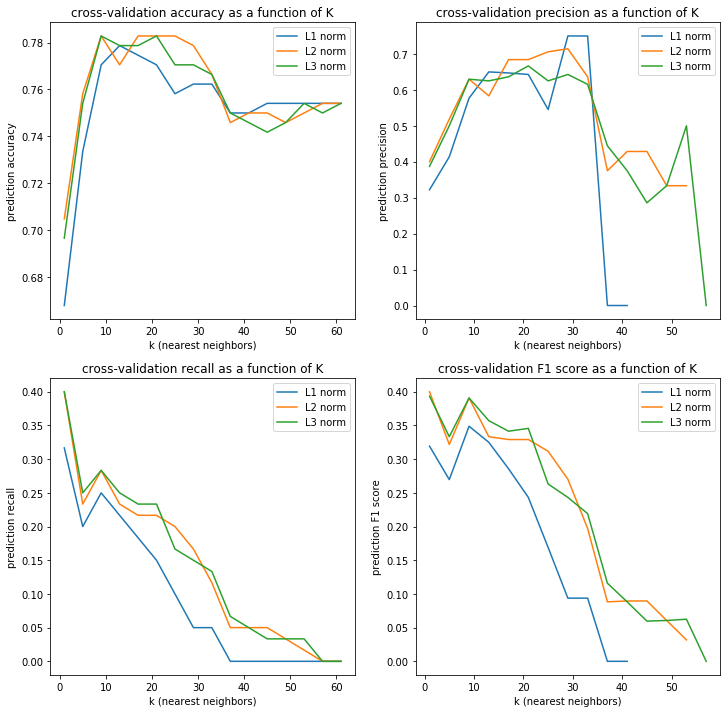

In [26]:
evaluation_L1 = conf_attributes(eval_L1)
evaluation_L2 = conf_attributes(eval_L2)
evaluation_L3 = conf_attributes(eval_L3)

fig=plt.figure(figsize=(12,12))
for ii,param in enumerate(evaluation_L1):
    ax=plt.subplot(2,2,ii+1)
    ax.plot(k_test,evaluation_L1[param], label="L1 norm")
    ax.plot(k_test,evaluation_L2[param], label="L2 norm")
    ax.plot(k_test,evaluation_L3[param], label="L3 norm")
    ax.set_ylabel("prediction "+param)
    ax.set_xlabel("k (nearest neighbors)");
    plt.title("cross-validation "+param+" as a function of K")
    plt.legend()

The best results are obtained with $\mathcal{L}_3$ norm and K=21. It could be worth testing higher order norms such as $\mathcal{L}_4$ or $\mathcal{L}_\infty$ (not implemented in the *K_nearest_neighbors* class)


The full training set is then used to train the data, and its performance is evaluated on the training set.

In [27]:
kk = 21
dist_norm = 3

knn = k_nearest_neighbors()
knn.fit(X_train, y_train)
confusion = knn.confusion_matrix(X_test, y_test, k=kk, dist_norm=dist_norm)
evaluation = conf_attributes(confusion)

print("The confusion matrix is:\n")
print("                 | Predict malignant | Predict benign |")
print("-----------------|------------------------------------|")
print("Actual malignant |          %5d    |       %5d    |"%(confusion[1,1],confusion[1,0]))
print("-----------------|------------------------------------|")
print("Actual benign    |          %5d    |       %5d    |"%(confusion[0,1],confusion[0,0]))
print("-----------------|------------------------------------|")

print("\nEvaluation metrics are :")
for key,val in evaluation.items():
    print(key+" = %5.3f"%val)

The confusion matrix is:

                 | Predict malignant | Predict benign |
-----------------|------------------------------------|
Actual malignant |              6    |          15    |
-----------------|------------------------------------|
Actual benign    |              4    |          37    |
-----------------|------------------------------------|

Evaluation metrics are :
accuracy = 0.694
precision = 0.600
recall = 0.286
F1 score = 0.387


The KNN algorithm performance is much worse than with the Breast Cancer Wisconsin dataset. This could be expected looking at the pair plot: there does not seem to be a clear boundary between the surviving and non surviving patients, based on the few features provided.